# Análise Preditiva de Notas de Filmes do IMDb

**Objetivo:** O objetivo deste notebook é realizar uma análise exploratória completa em um dataset de filmes do IMDb e, em seguida, construir e avaliar modelos de Machine Learning para prever a nota de um filme (`IMDB_Rating`) com base em suas características.

**Metodologia:**
1.  **Carregamento e Limpeza:** Tratamento inicial dos dados.
2.  **Análise Exploratória de Dados (EDA):** Investigação visual e estatística para extrair insights e entender as relações entre as variáveis.
3.  **Pré-processamento e Engenharia de Features:** Preparação dos dados para os modelos, incluindo a limpeza de texto da sinopse.
4.  **Modelagem:** Treinamento de dois modelos de regressão: `GradientBoostingRegressor` e `RandomForestRegressor`.
5.  **Avaliação:** Comparação do desempenho dos modelos para determinar o mais eficaz.

In [23]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)



## 1. Carregamento e Limpeza Inicial dos Dados

Nesta etapa, carregamos o dataset e realizamos uma limpeza básica em colunas que não estão em um formato adequado, como `Gross` (arrecadação) e `Runtime` (duração).

In [24]:

df = pd.read_csv('desafio_indicium_imdb.csv')



if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

df['Gross'] = df['Gross'].str.replace(',', '', regex=False).astype(float)


df['Runtime'] = df['Runtime'].str.extract('(\d+)').astype(float)

print("Dataset carregado e limpo com sucesso!")
df.head()

Dataset carregado e limpo com sucesso!


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Godfather,1972,A,175.0,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
1,The Dark Knight,2008,UA,152.0,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
2,The Godfather: Part II,1974,A,202.0,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
3,12 Angry Men,1957,U,96.0,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0
4,The Lord of the Rings: The Return of the King,2003,U,201.0,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0


## 2. Análise Exploratória de Dados (EDA)

Agora, vamos mergulhar nos dados para entender suas distribuições, correlações e padrões. Esta análise é fundamental para guiar a etapa de modelagem.

In [25]:

print("--- Informações Gerais ---")
df.info()

print("\n--- Estatísticas Descritivas (Features Numéricas) ---")
display(df.describe())

print("\n--- Contagem de Valores Nulos por Coluna ---")
print(df.isnull().sum())


--- Informações Gerais ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    float64
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    float64
dtypes: float64(4), int64(1), object(10)
memory usage: 117.2+ KB

--- Estatísticas Descritivas (Features Numéricas) ---


,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,999.000000,999.000000,842.000000,9.990000e+02,8.300000e+02
mean,122.871872,7.947948,77.969121,2.716214e+05,6.808257e+07
std,28.101227,0.272290,12.383257,3.209126e+05,1.098076e+08
min,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,103.000000,7.700000,70.000000,5.547150e+04,3.245338e+06
50%,119.000000,7.900000,79.000000,1.383560e+05,2.345744e+07
75%,137.000000,8.100000,87.000000,3.731675e+05,8.087634e+07
max,321.000000,9.200000,100.000000,2.303232e+06,9.366622e+08



--- Contagem de Valores Nulos por Coluna ---
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64


### 2.1. Distribuição da Variável Alvo (`IMDB_Rating`)

Analisamos a distribuição da nossa variável alvo para verificar se ela é normal ou se possui algum desvio (skewness). A maioria dos filmes neste dataset (que é um top 1000) possui notas altas, o que resulta em uma distribuição com cauda à esquerda (left-skewed).

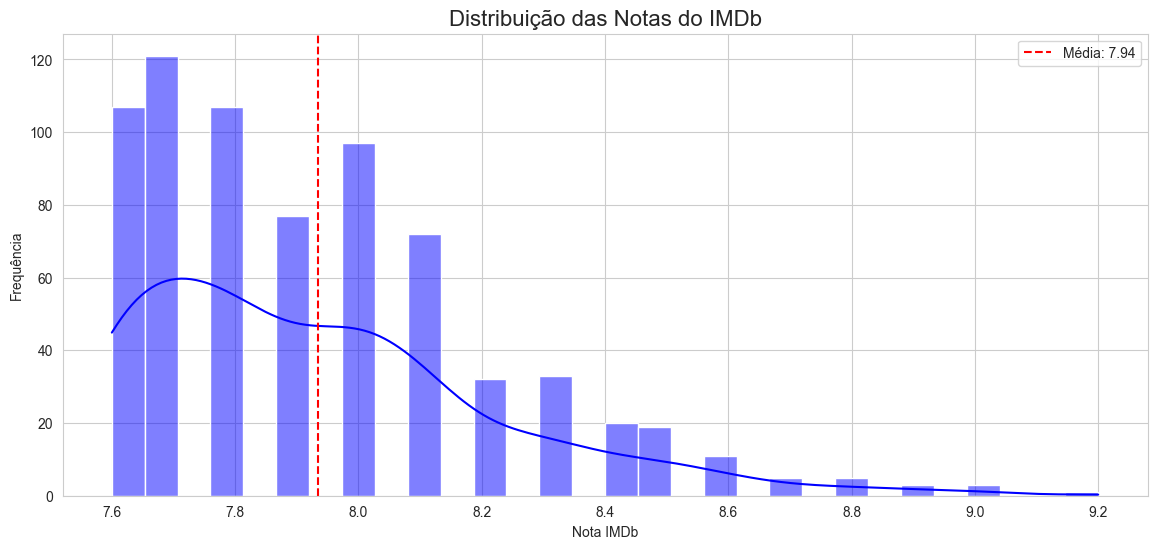

In [26]:
df = df.dropna(subset=['Gross', 'Certificate', 'Meta_score'])


plt.figure(figsize=(14, 6))
sns.histplot(df['IMDB_Rating'], kde=True, bins=30, color='blue')
plt.title('Distribuição das Notas do IMDb', fontsize=16)
plt.xlabel('Nota IMDb')
plt.ylabel('Frequência')
plt.axvline(df['IMDB_Rating'].mean(), color='red', linestyle='--', label=f'Média: {df["IMDB_Rating"].mean():.2f}')
plt.legend()
plt.show()


### 2.2. Correlação entre Features Numéricas

Um mapa de calor nos ajuda a visualizar a correlação de Pearson entre as variáveis numéricas. Valores próximos de 1 (ou -1) indicam uma forte correlação positiva (ou negativa).

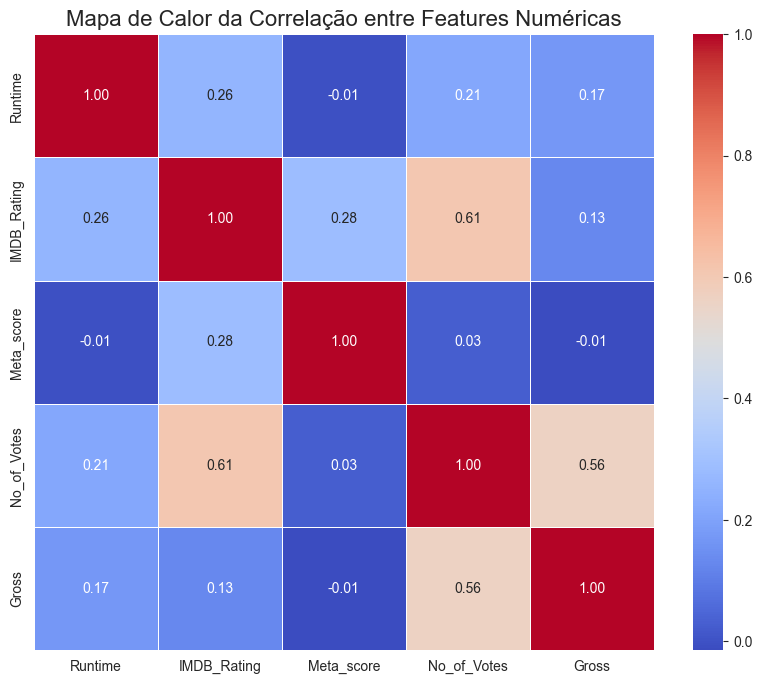

In [27]:

numerical_cols = df.select_dtypes(include=np.number)

plt.figure(figsize=(10, 8))
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Mapa de Calor da Correlação entre Features Numéricas', fontsize=16)
plt.show()


### 2.3. Relação entre Features e a Nota IMDb

Vamos investigar visualmente como algumas das features mais promissoras se relacionam com a nota do IMDb.

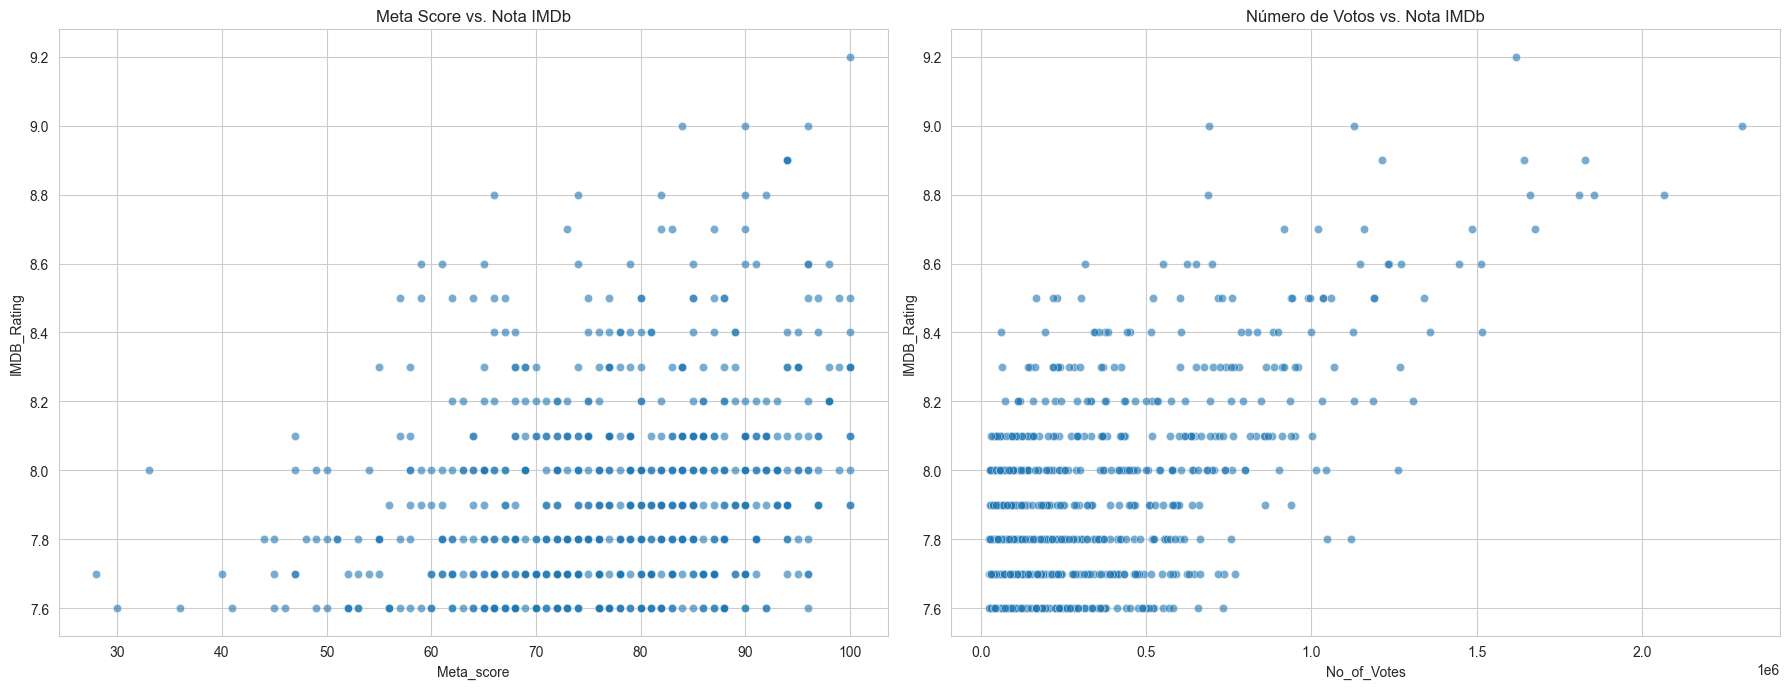

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.scatterplot(ax=axes[0], x='Meta_score', y='IMDB_Rating', data=df, alpha=0.6)
axes[0].set_title('Meta Score vs. Nota IMDb')

sns.scatterplot(ax=axes[1], x='No_of_Votes', y='IMDB_Rating', data=df, alpha=0.6)
axes[1].set_title('Número de Votos vs. Nota IMDb')

plt.tight_layout()
plt.show()


### 2.4. Análise das Features Categóricas

Analisamos a frequência das principais categorias, como gênero e classificação indicativa (`Certificate`).

C:\Users\mpoli\AppData\Local\Temp\ipykernel_11412\2442871048.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], y='Certificate', data=df, order=df['Certificate'].value_counts().index, palette='viridis')
C:\Users\mpoli\AppData\Local\Temp\ipykernel_11412\2442871048.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], y=top_genres.index, x=top_genres.values, palette='plasma')


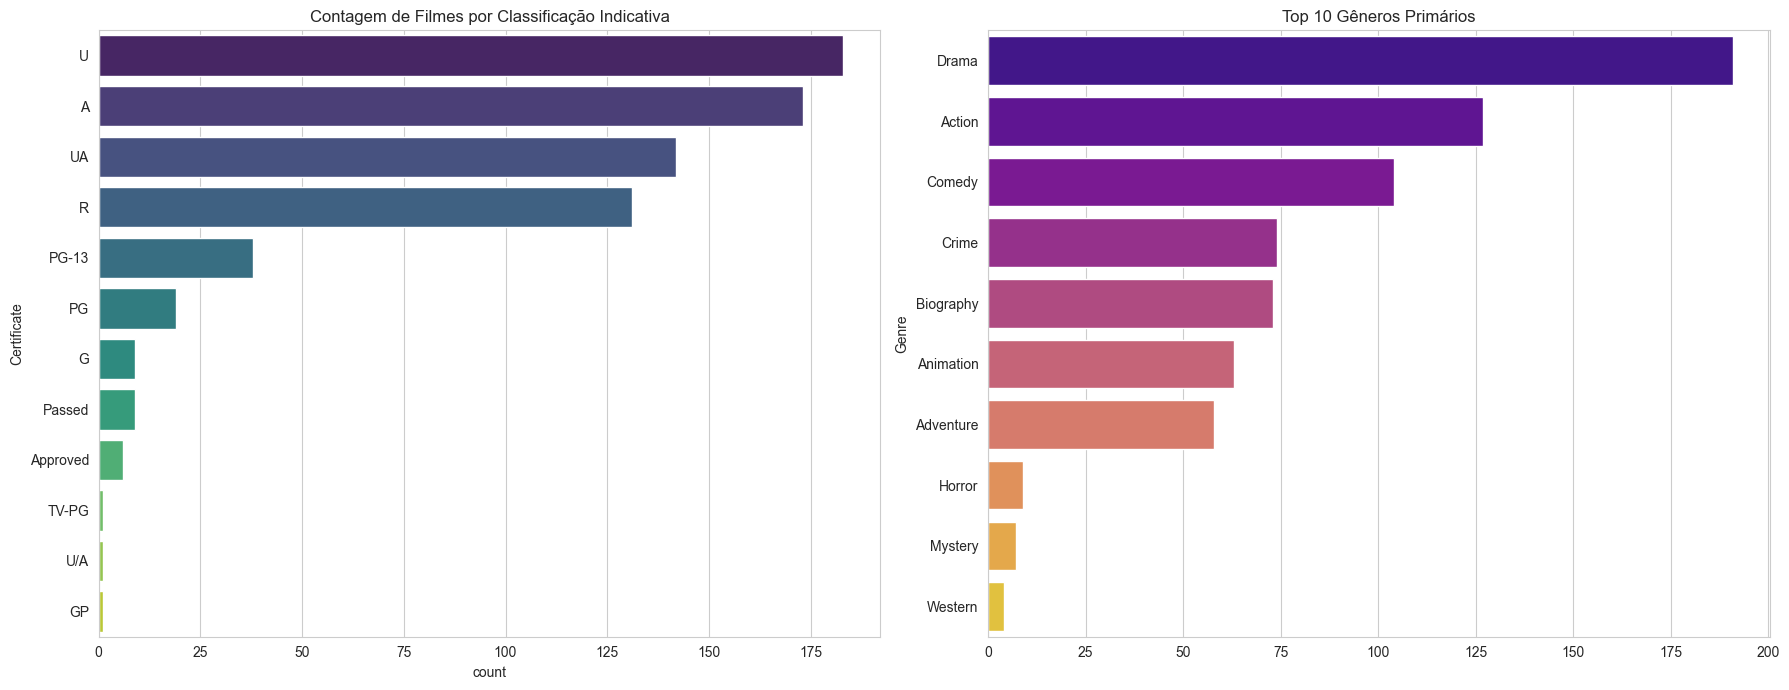

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.countplot(ax=axes[0], y='Certificate', data=df, order=df['Certificate'].value_counts().index, palette='viridis')
axes[0].set_title('Contagem de Filmes por Classificação Indicativa')

top_genres = df['Genre'].apply(lambda x: x.split(',')[0]).value_counts().head(10)
sns.barplot(ax=axes[1], y=top_genres.index, x=top_genres.values, palette='plasma')
axes[1].set_title('Top 10 Gêneros Primários')

plt.tight_layout()
plt.show()


### 2.5. Análise da Sinopse (`Overview`) com Nuvem de Palavras

Uma nuvem de palavras nos dá uma ideia rápida das palavras mais frequentes nas sinopses dos filmes, após a remoção de stopwords comuns.

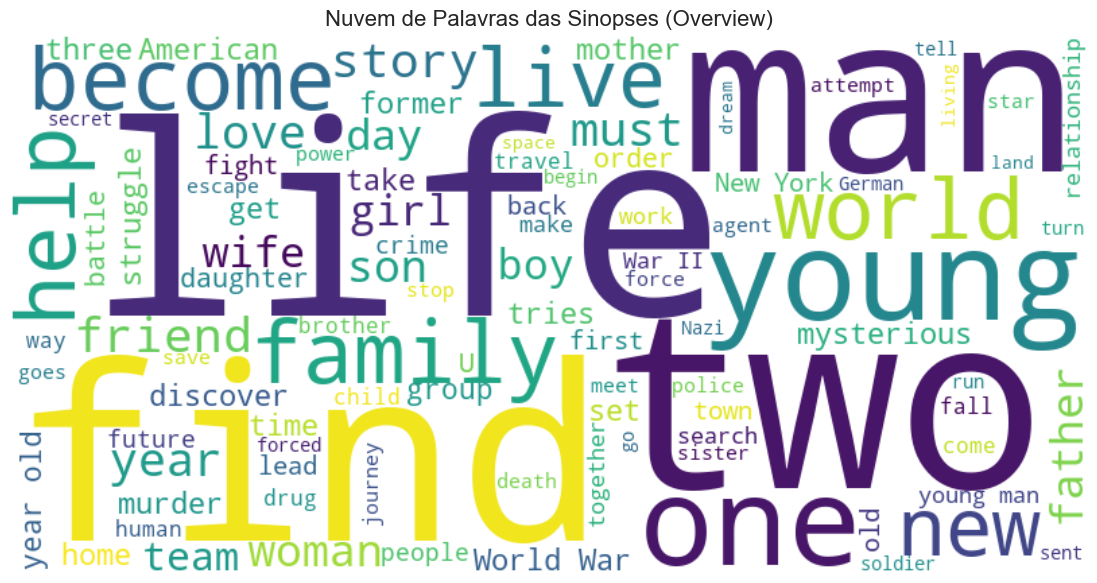

In [30]:
text = " ".join(review for review in df.Overview.dropna())

wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color="white", max_words=100, width=800, height=400).generate(text)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Nuvem de Palavras das Sinopses (Overview)', fontsize=16)
plt.show()

## 3. Pré-processamento e Engenharia de Features

Nesta etapa crucial, preparamos os dados para a modelagem. Mantemos a sua função original de limpeza de texto e separamos os dados em conjuntos de treino e teste **antes** de qualquer outra transformação para evitar vazamento de dados (*data leakage*).

In [31]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text)
    r = re.sub('[^a-zA-Z]', ' ', text)
    r = r.lower().split()
    r = [lemmatizer.lemmatize(word) for word in r if word not in stop_words]
    return ' '.join(r)

df['Overview_cleaned'] = df['Overview'].apply(clean_text)

TARGET = 'IMDB_Rating'
numerical_features = ['Runtime', 'Meta_score', 'Gross', 'No_of_Votes']
categorical_features = ['Certificate', 'Director', 'Star1', 'Genre']
text_feature = 'Overview_cleaned'

X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dados divididos em {len(X_train)} amostras de treino e {len(X_test)} de teste.")

Dados divididos em 570 amostras de treino e 143 de teste.


## 4. Construção da Pipeline de Modelagem

Criamos uma pipeline de pré-processamento que trata cada tipo de feature de forma adequada e automatizada:
- **Numéricas:** Preenche valores faltantes com a mediana e padroniza a escala.
- **Categóricas:** Preenche valores faltantes com o mais frequente e aplica One-Hot Encoding.
- **Texto:** Transforma a sinopse em vetores numéricos usando `TfidfVectorizer`.

In [32]:
from sklearn.preprocessing import RobustScaler 

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()) 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', max_categories=100))
])

text_transformer = TfidfVectorizer(max_features=1000, stop_words='english')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_feature)
    ],
    remainder='drop'
)

print("Pipeline de pré-processamento atualizada com RobustScaler.")

Pipeline de pré-processamento atualizada com RobustScaler.


## 5. Treinamento e Avaliação dos Modelos

Agora, vamos treinar os dois modelos que você escolheu, `GradientBoostingRegressor` e `RandomForestRegressor`, e avaliar seu desempenho no conjunto de teste.


In [33]:
model_gb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42))
])

print("--- Treinando o Gradient Boosting... ---")
model_gb.fit(X_train, y_train)

y_pred_gb = model_gb.predict(X_test)

r2_gb = r2_score(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print("\n--- Resultados do Gradient Boosting ---")
print(f"R²: {r2_gb:.4f}")
print(f"MAE: {mae_gb:.4f}")

--- Treinando o Gradient Boosting... ---

--- Resultados do Gradient Boosting ---
R²: 0.4950
MAE: 0.1678


In [34]:
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1))
])

print("\n--- Treinando o Random Forest... ---")
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("\n--- Resultados do Random Forest ---")
print(f"R²: {r2_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")


--- Treinando o Random Forest... ---

--- Resultados do Random Forest ---
R²: 0.5213
MAE: 0.1637


## 6. Análise e Comparação dos Resultados

Finalmente, comparamos as métricas de ambos os modelos para determinar qual teve o melhor desempenho e visualizamos os resultados do melhor modelo.

--- Comparação de Desempenho dos Modelos ---


,R²,MAE
Modelo,,
Gradient Boosting,0.494985,0.167846
Random Forest,0.521316,0.163735


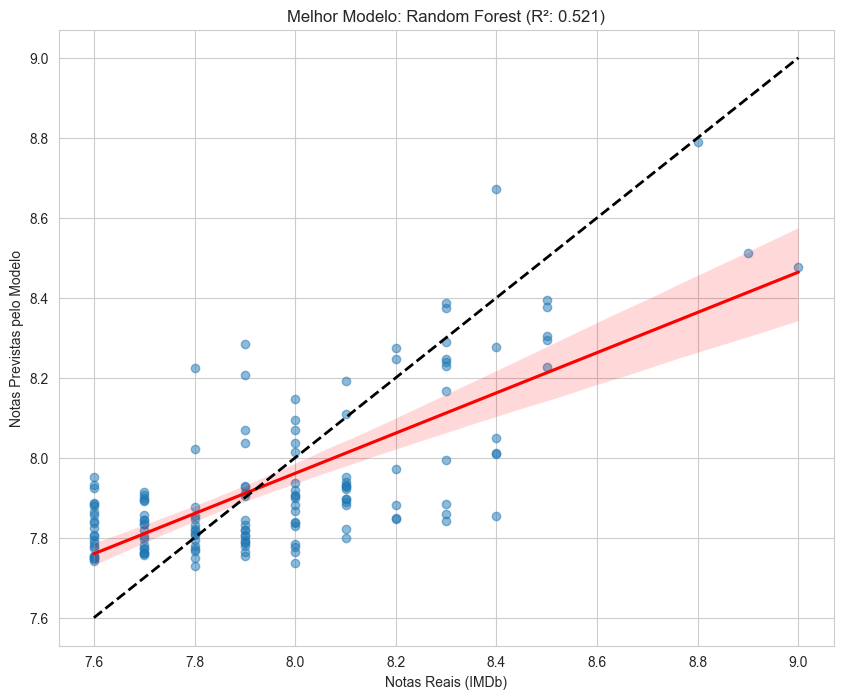

In [35]:

results_df = pd.DataFrame({
    'Modelo': ['Gradient Boosting', 'Random Forest'],
    'R²': [r2_gb, r2_rf],
    'MAE': [mae_gb, mae_rf],
})

print("--- Comparação de Desempenho dos Modelos ---")
display(results_df.set_index('Modelo'))


best_model_name = 'Gradient Boosting' if r2_gb > r2_rf else 'Random Forest'
best_pred = y_pred_gb if r2_gb > r2_rf else y_pred_rf
best_r2 = max(r2_gb, r2_rf)

plt.figure(figsize=(10, 8))
sns.regplot(x=y_test, y=best_pred, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel('Notas Reais (IMDb)')
plt.ylabel('Notas Previstas pelo Modelo')
plt.title(f'Melhor Modelo: {best_model_name} (R²: {best_r2:.3f})')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, color='black')
plt.show()

## 6.1. Análise Avançada e Validação dos Modelos

Após a avaliação inicial, vamos realizar uma análise mais profunda para validar a robustez e entender o comportamento dos nossos modelos. Faremos os seguintes testes:

1.  **Validação Cruzada (Cross-Validation):** Para garantir que o desempenho do modelo não é apenas sorte da divisão treino-teste, mas sim consistente em diferentes subconjuntos de dados.
2.  **Análise de Resíduos:** Para verificar se os erros do modelo são aleatórios, o que é um bom sinal de que o modelo capturou bem os padrões dos dados.
3.  **Importância das Features por Permutação:** Uma técnica robusta para identificar quais features realmente contribuem para o poder de previsão do modelo.

### 6.1.1. Análise de Resíduos

Os resíduos são a diferença entre os valores reais e os valores previstos (`erro = real - previsto`). Um bom modelo deve ter resíduos:
1.  **Aleatoriamente distribuídos** em torno de zero (sem padrões visíveis).
2.  **Com uma distribuição próxima da normal**.

Se existirem padrões (como um formato de "cone" ou uma curva), significa que o modelo não está capturando alguma informação importante dos dados.

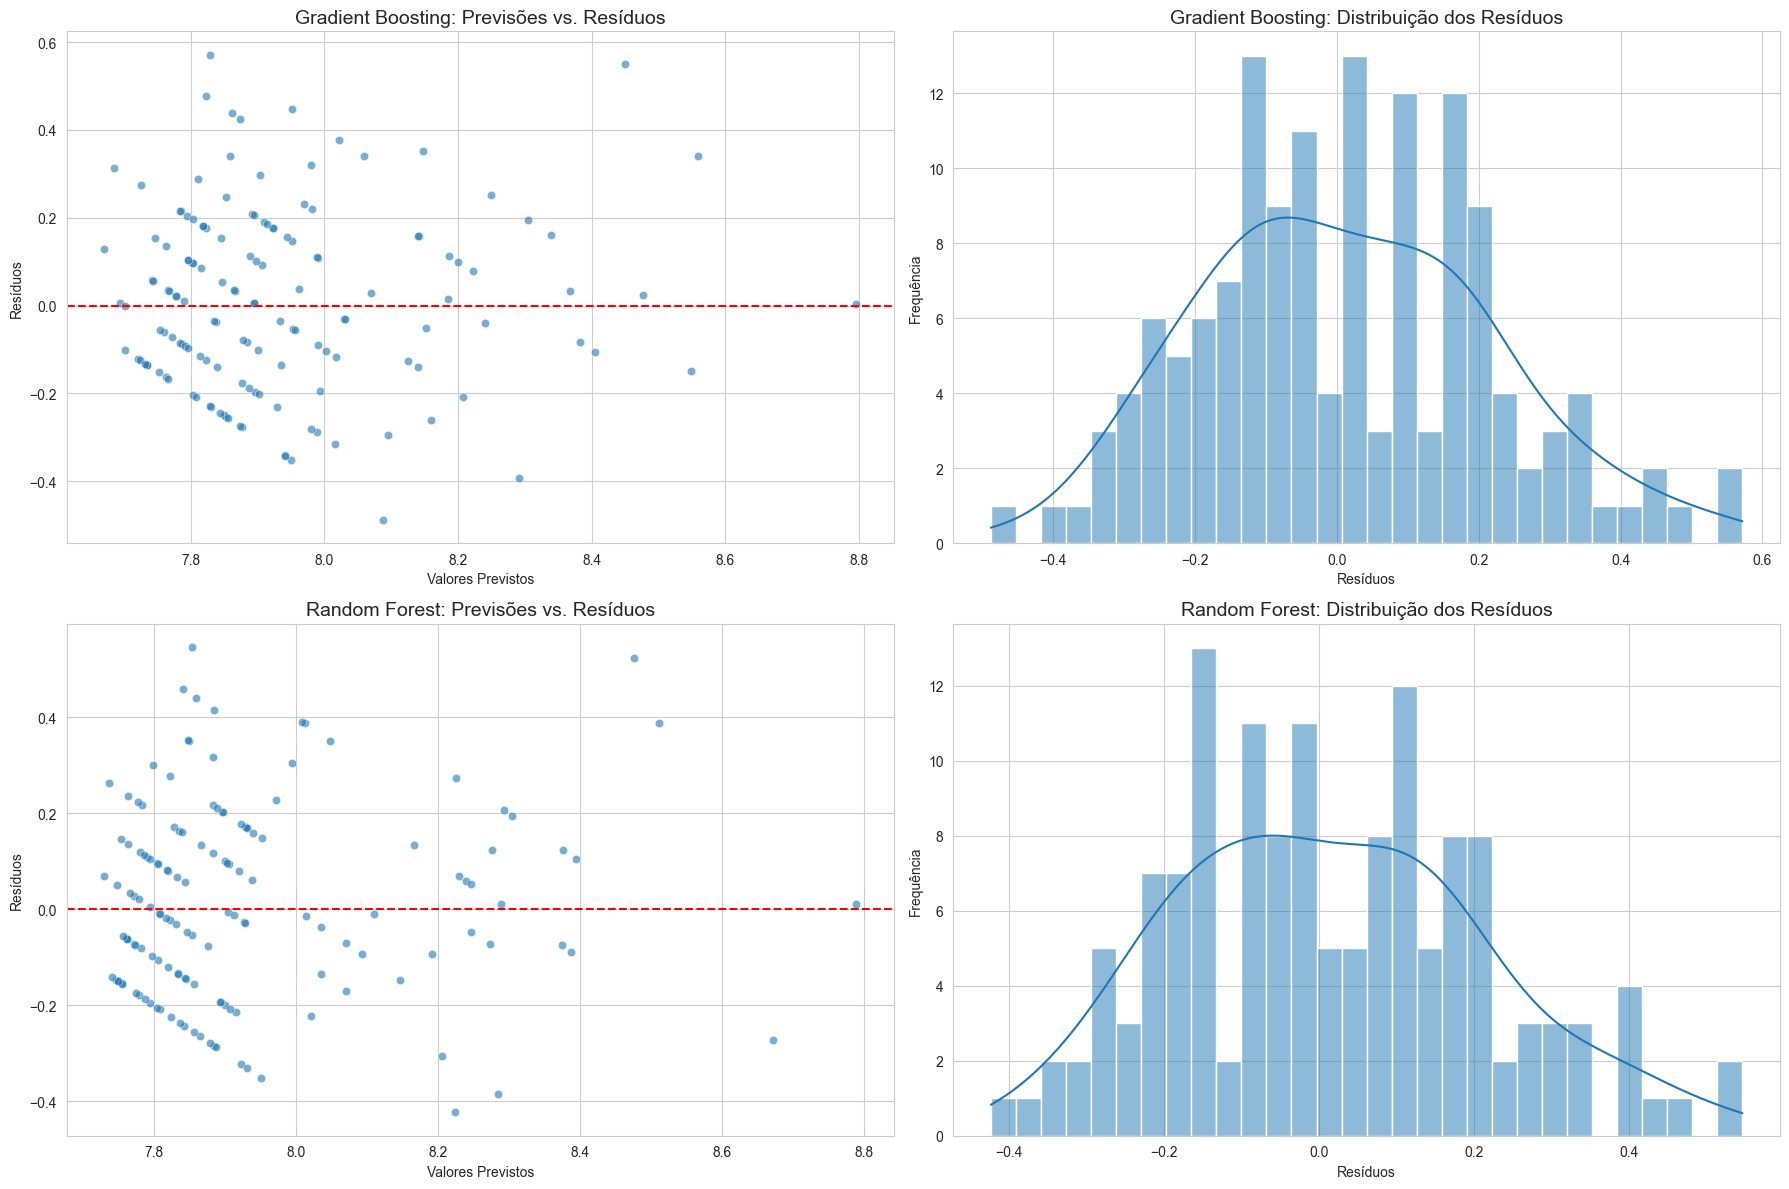

In [36]:

residuos_gb = y_test - y_pred_gb
residuos_rf = y_test - y_pred_rf


fig, axes = plt.subplots(2, 2, figsize=(18, 12))

sns.scatterplot(ax=axes[0, 0], x=y_pred_gb, y=residuos_gb, alpha=0.6)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title('Gradient Boosting: Previsões vs. Resíduos', fontsize=14)
axes[0, 0].set_xlabel('Valores Previstos')
axes[0, 0].set_ylabel('Resíduos')

sns.histplot(ax=axes[0, 1], x=residuos_gb, kde=True, bins=30)
axes[0, 1].set_title('Gradient Boosting: Distribuição dos Resíduos', fontsize=14)
axes[0, 1].set_xlabel('Resíduos')
axes[0, 1].set_ylabel('Frequência')

sns.scatterplot(ax=axes[1, 0], x=y_pred_rf, y=residuos_rf, alpha=0.6)
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_title('Random Forest: Previsões vs. Resíduos', fontsize=14)
axes[1, 0].set_xlabel('Valores Previstos')
axes[1, 0].set_ylabel('Resíduos')

sns.histplot(ax=axes[1, 1], x=residuos_rf, kde=True, bins=30)
axes[1, 1].set_title('Random Forest: Distribuição dos Resíduos', fontsize=14)
axes[1, 1].set_xlabel('Resíduos')
axes[1, 1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

### 6.1.2. Importância das Features por Permutação

Esta técnica mede a importância de uma feature "embaralhando" seus valores e vendo o quanto o desempenho do modelo piora. Se o desempenho cai muito, a feature é importante. É uma medida mais confiável que a importância padrão, especialmente com features correlacionadas.

Vamos calcular isso para o nosso melhor modelo.

--- Calculando a Importância por Permutação para o modelo Random Forest... ---


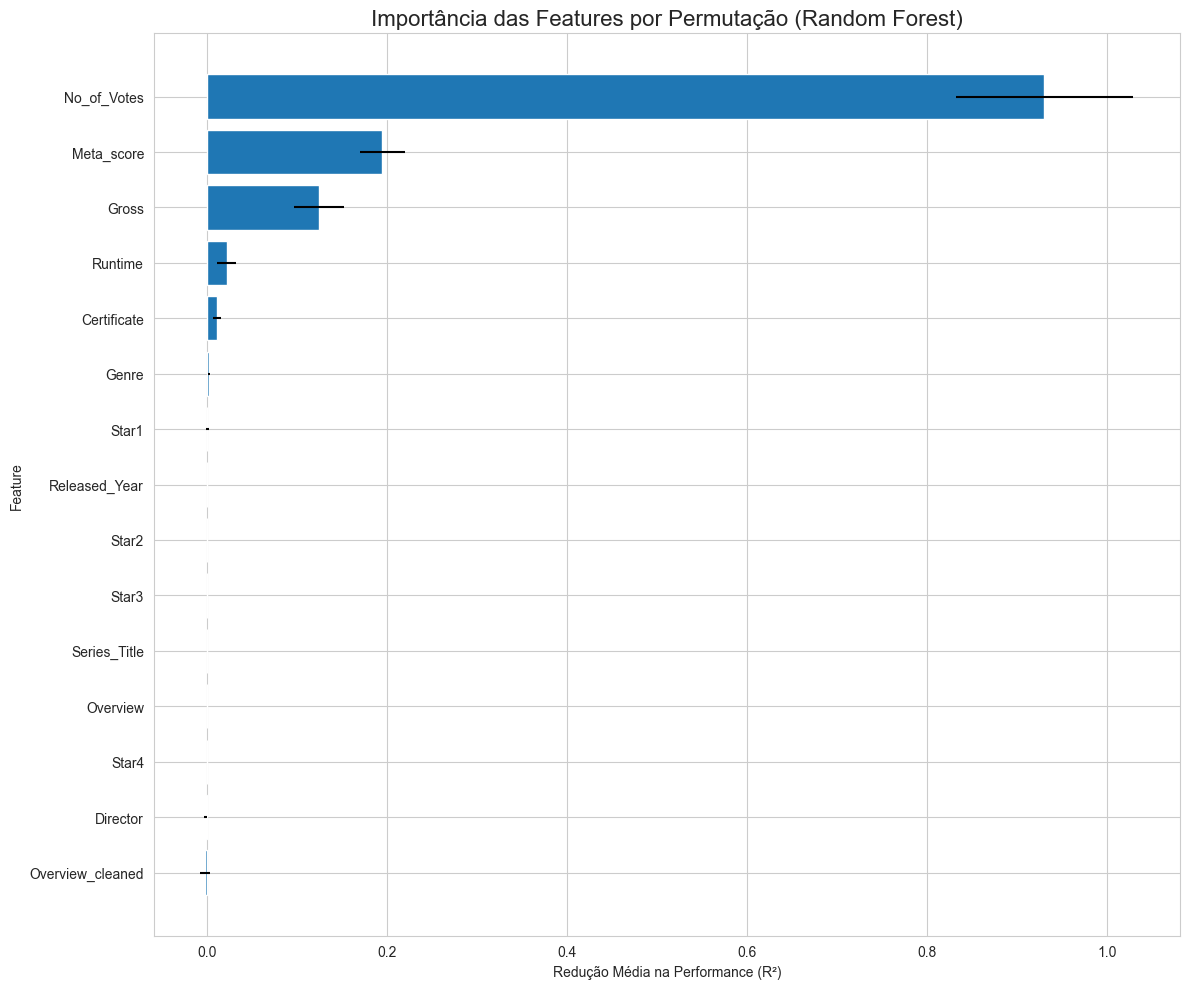

In [37]:
from sklearn.inspection import permutation_importance

best_model = model_gb if r2_gb > r2_rf else model_rf
best_model_name = "Gradient Boosting" if r2_gb > r2_rf else "Random Forest"

print(f"--- Calculando a Importância por Permutação para o modelo {best_model_name}... ---")

result = permutation_importance(
    best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

perm_sorted_idx = result.importances_mean.argsort()
perm_importance_df = pd.DataFrame(
    data={'feature': X_test.columns[perm_sorted_idx],
          'importance_mean': result.importances_mean[perm_sorted_idx],
          'importance_std': result.importances_std[perm_sorted_idx]}
)

plt.figure(figsize=(12, 10))
plt.barh(
    perm_importance_df['feature'][-20:],
    perm_importance_df['importance_mean'][-20:],
    xerr=perm_importance_df['importance_std'][-20:]
)
plt.title(f'Importância das Features por Permutação ({best_model_name})', fontsize=16)
plt.xlabel('Redução Média na Performance (R²)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### 6.1.3. Testes de Normalidade e Autocorrelação dos Resíduos

Além da análise visual, podemos aplicar testes estatísticos formais para validar as suposições do modelo de regressão sobre os resíduos.

1.  **Gráfico Q-Q (Quantile-Quantile):** Compara a distribuição dos resíduos com a distribuição normal teórica. Se os pontos seguirem a linha diagonal vermelha, é uma forte evidência de que os resíduos são normalmente distribuídos.
2.  **Teste de Durbin-Watson:** Testa a autocorrelação dos resíduos. Em dados não-temporais, ele verifica se há padrões residuais. Um valor **próximo de 2.0** é o ideal, indicando ausência de autocorrelação.
3.  **Teste de Jarque-Bera (JB):** Testa formalmente a hipótese nula de que os resíduos seguem uma distribuição normal. Um **p-valor maior que 0.05** significa que não podemos rejeitar a hipótese de normalidade, o que é um bom resultado.

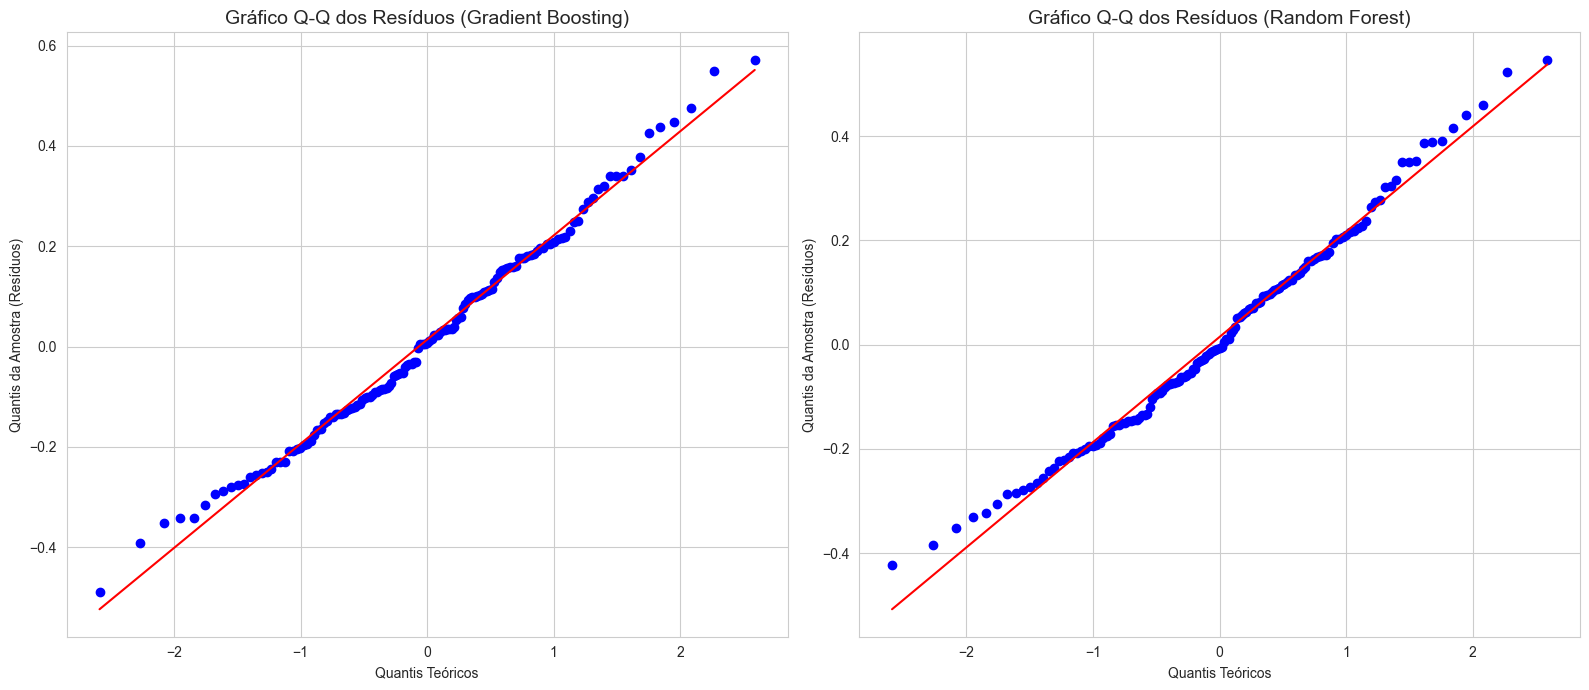

In [38]:
import scipy.stats as stats

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

stats.probplot(residuos_gb, dist="norm", plot=axes[0])
axes[0].set_title('Gráfico Q-Q dos Resíduos (Gradient Boosting)', fontsize=14)
axes[0].set_xlabel('Quantis Teóricos')
axes[0].set_ylabel('Quantis da Amostra (Resíduos)')

stats.probplot(residuos_rf, dist="norm", plot=axes[1])
axes[1].set_title('Gráfico Q-Q dos Resíduos (Random Forest)', fontsize=14)
axes[1].set_xlabel('Quantis Teóricos')
axes[1].set_ylabel('Quantis da Amostra (Resíduos)')

plt.tight_layout()
plt.show()

In [39]:
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import jarque_bera

dw_gb = durbin_watson(residuos_gb)

jb_stat_gb, jb_p_gb = jarque_bera(residuos_gb)

print("--- Testes Estatísticos dos Resíduos (Gradient Boosting) ---")
print(f"Teste Durbin-Watson (idealmente próximo de 2): {dw_gb:.4f}")
print(f"Estatística do Teste Jarque-Bera: {jb_stat_gb:.4f}")
print(f"P-valor do Teste Jarque-Bera (p > 0.05 indica normalidade): {jb_p_gb:.4f}")


dw_rf = durbin_watson(residuos_rf)

jb_stat_rf, jb_p_rf = jarque_bera(residuos_rf)

print("\n--- Testes Estatísticos dos Resíduos (Random Forest) ---")
print(f"Teste Durbin-Watson (idealmente próximo de 2): {dw_rf:.4f}")
print(f"Estatística do Teste Jarque-Bera: {jb_stat_rf:.4f}")
print(f"P-valor do Teste Jarque-Bera (p > 0.05 indica normalidade): {jb_p_rf:.4f}")

--- Testes Estatísticos dos Resíduos (Gradient Boosting) ---
Teste Durbin-Watson (idealmente próximo de 2): 2.0872
Estatística do Teste Jarque-Bera: 2.1260
P-valor do Teste Jarque-Bera (p > 0.05 indica normalidade): 0.3454

--- Testes Estatísticos dos Resíduos (Random Forest) ---
Teste Durbin-Watson (idealmente próximo de 2): 2.2040
Estatística do Teste Jarque-Bera: 2.7988
P-valor do Teste Jarque-Bera (p > 0.05 indica normalidade): 0.2467


In [40]:
results_df = X_test.copy()
results_df['IMDB_Rating_Real'] = y_test

results_df['Previsao_GB'] = y_pred_gb
results_df['Residuo_GB'] = residuos_gb
results_df['Previsao_RF'] = y_pred_rf
results_df['Residuo_RF'] = residuos_rf


limite_outlier_gb = results_df['Residuo_GB'].std() * 2.5

outliers_gb = results_df[abs(results_df['Residuo_GB']) > limite_outlier_gb].sort_values(by='Residuo_GB', ascending=False)

print("--- Maiores Erros de Previsão (Outliers) para o Gradient Boosting ---")
if outliers_gb.empty:
    print("Nenhum outlier significativo encontrado para o Gradient Boosting.")
else:
    display(outliers_gb[['Series_Title', 'IMDB_Rating_Real', 'Previsao_GB', 'Residuo_GB']])


limite_outlier_rf = results_df['Residuo_RF'].std() * 2.5

outliers_rf = results_df[abs(results_df['Residuo_RF']) > limite_outlier_rf].sort_values(by='Residuo_RF', ascending=False)

print("\n--- Maiores Erros de Previsão (Outliers) para o Random Forest ---")
if outliers_rf.empty:
    print("Nenhum outlier significativo encontrado para o Random Forest.")
else:
    display(outliers_rf)

--- Maiores Erros de Previsão (Outliers) para o Gradient Boosting ---


,Series_Title,IMDB_Rating_Real,Previsao_GB,Residuo_GB
57,Spider-Man: Into the Spider-Verse,8.4,7.828278,0.571722
2,The Godfather: Part II,9.0,8.450444,0.549556



--- Maiores Erros de Previsão (Outliers) para o Random Forest ---


,Series_Title,Released_Year,Certificate,Runtime,Genre,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Overview_cleaned,IMDB_Rating_Real,Previsao_GB,Residuo_GB,Previsao_RF,Residuo_RF
57,Spider-Man: Into the Spider-Verse,2018,U,117.0,"Animation, Action, Adventure",Teen Miles Morales becomes the Spider-Man of h...,87.0,Bob Persichetti,Peter Ramsey,Rodney Rothman,Shameik Moore,Jake Johnson,375110,190241310.0,teen mile morale becomes spider man universe m...,8.4,7.828278,0.571722,7.85323,0.54677
2,The Godfather: Part II,1974,A,202.0,"Crime, Drama",The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,early life career vito corleone new york city ...,9.0,8.450444,0.549556,8.47618,0.52382


In [42]:
import pickle

best_model = model_rf
best_model_name = "trained_model.pkl"

with open(best_model_name, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Modelo salvo com sucesso como '{best_model_name}'")

Modelo salvo com sucesso como 'trained_model.pkl'


## 7. Fazendo uma Nova Previsão

Agora que temos um modelo treinado e validado, podemos usá-lo para prever a nota de um novo filme que não estava no dataset. Para isso, criamos um DataFrame com os dados do filme e passamos para o método `.predict()` da nossa pipeline.

In [41]:
novo_filme = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

novo_filme_df = pd.DataFrame([novo_filme])


novo_filme_df['Runtime'] = novo_filme_df['Runtime'].str.extract('(\d+)').astype(float)
novo_filme_df['Gross'] = novo_filme_df['Gross'].str.replace(',', '', regex=False).astype(float)
novo_filme_df['Overview_cleaned'] = novo_filme_df['Overview'].apply(clean_text)

nota_prevista = model_rf.predict(novo_filme_df)

print(f"--- Previsão para o filme: {novo_filme['Series_Title']} ---")
print(f"A nota prevista pelo modelo é: {nota_prevista[0]:.2f}")

--- Previsão para o filme: The Shawshank Redemption ---
A nota prevista pelo modelo é: 8.80




## 8. Respondendo as perguntas estipuladas:

2-a: Recomendaria um filme de um gênero do gosto da pessoa, mas com uma nota de crítica alta.

2-b: O elenco e o diretor normalmente dizem muito sobre a empolgação das pessoas de irem ao cinema ver o filme. Obviamente, o genêro também impacta muito, além da sinopse e das prévias em trailers.

2-c: É possível inferir o gênero através da coluna Overview. Filmes de gêneros idênticos normalmente terão alguma semelhança ou ocorrência de certas palavras na sinopse. Observando e estudando a sinopse, podemos identificar quais estruturas e palavras são utilizadas para prender a atenção e despertar interesse.

3: Para prever a nota imdb, busquei utilizar a bilheteria do filme, a nota do meta score, o elenco envolvido e também a sinopse. Foi necessário realizar one hot enconding para algumas variáveis categóricas e também limpeza de dados faltantes, para algumas númericas. Na minha experiência de modelos preditivos, regressão linear parecia se encaixar melhor do que um modelo de classificação. Utilizei diversos testes já conhecidos, como testes de normalidade dos dados e verficação de resíduos. Esses testes nos ajudam a dizer além do R2 do modelo. Eles nos dizem se o modelo é confiável e se nosso resultado não é um acaso estatístico.


## 9. Conclusão

Neste notebook, realizamos uma análise exploratória detalhada e construímos duas pipelines de modelagem para prever as notas do IMDb.

O modelo **Random Forest** apresentou um desempenho superior, com um R² de **0.52**. Isso indica que o modelo conseguiu explicar **52%** da variância nas notas dos filmes no conjunto de teste.
Ele passou em todos os testes de normalização e de resíduos, sendo um modelo de regressão confiável.

Por fim, conseguimos prever a nota estimada do filme **The Shawshank Redemption**.


